In [1]:
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from sklearn import linear_model
import math

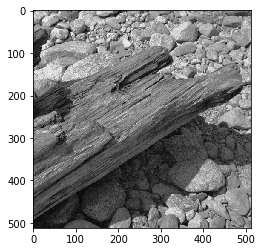

In [2]:
# Import Images
data = scipy.io.loadmat("IMAGES_RAW.mat")
images = data["IMAGESr"]
# Images is a 3D array of size [512,512,10] where the 10 images are of size 512 x 512

# Show the first image.
plt.imshow(images[:,:,0], cmap="gray")

# Function to sample image patches from the large images.
def sample_random_square_patches(image, num, width):
    patches =np.zeros([width*width,num]);
    for k in range(num):
        i, j = rd.sample(range(image.shape[0]-width),2)
        patches[:,k] = image[i:i+width,j:j+width].flatten()
    return patches

In [3]:
# Display codebook function
def display_codebook(X):
    nrows = 9
    ncols = 12
    plt.figure(figsize=(ncols, nrows))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(X[:,i].reshape((12,12)), cmap="gray")
        plt.axis("off")
    plt.axis("off")
    plt.show()

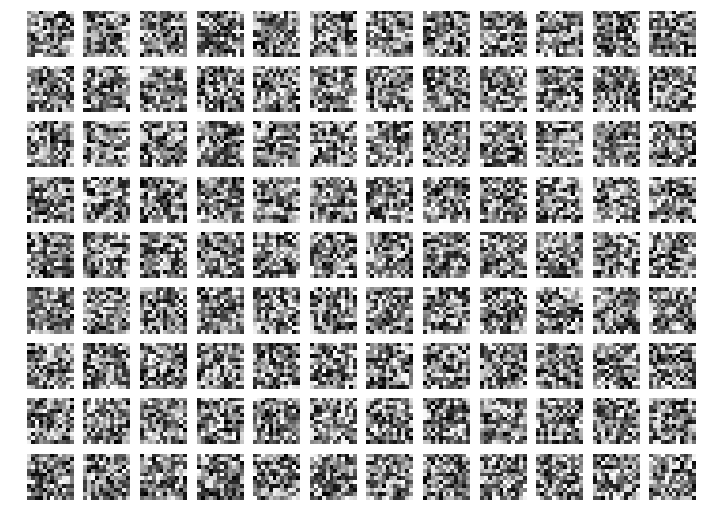

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


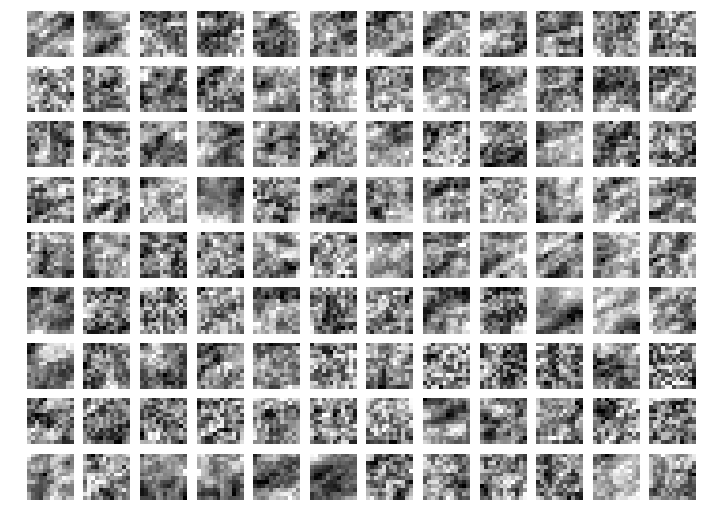

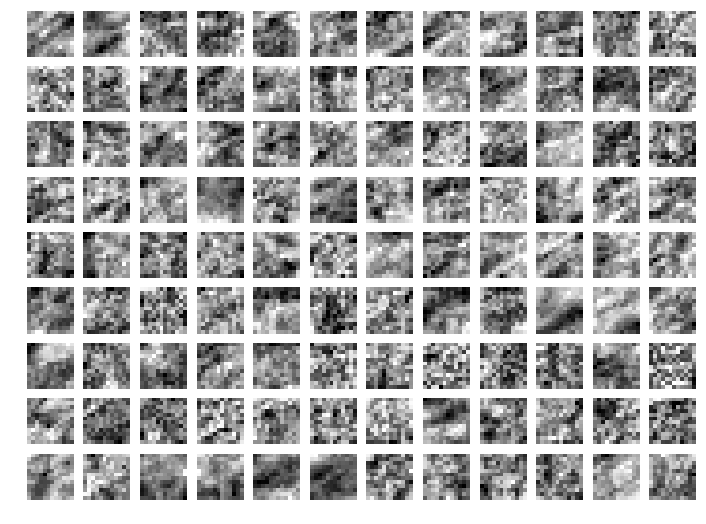

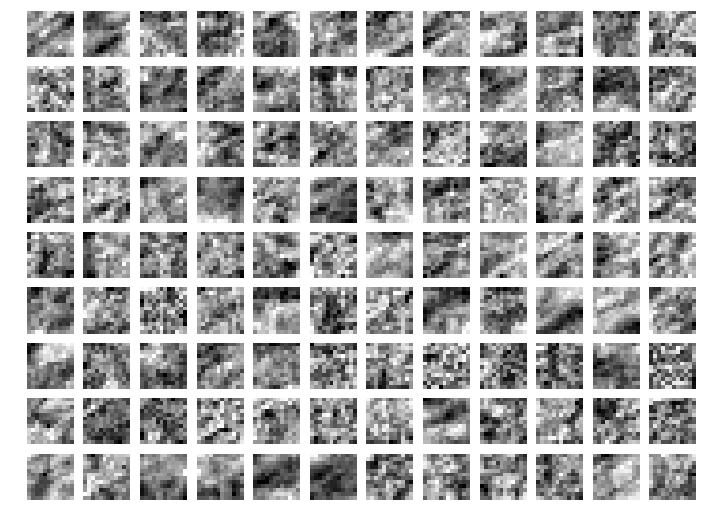

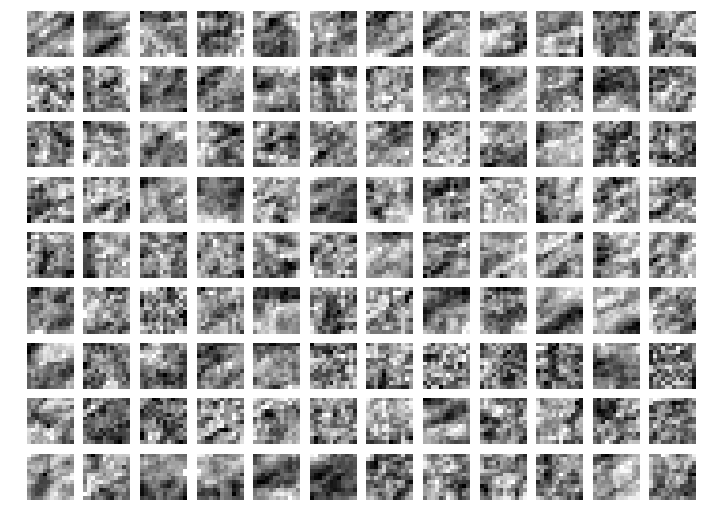

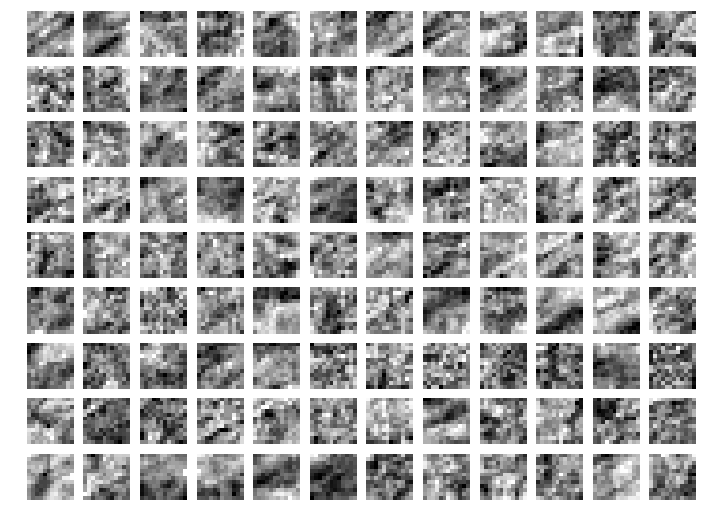

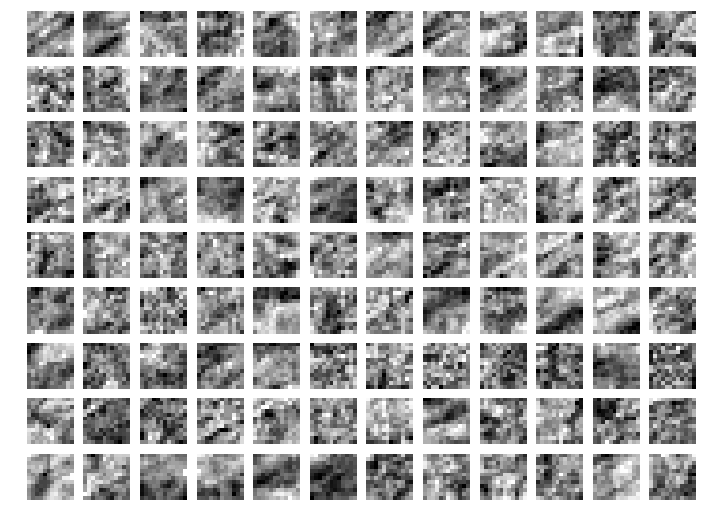

In [16]:
# Randomly Initialize 108 basis functions, X
X = np.random.rand(144,108)

# Display the codebook after initialization
display_codebook(X)

# Create the Lasso class for coefficient estimation
# After experiments, alpha = 0.0014 is optimum
lasso =linear_model.Lasso(alpha=0.0014, fit_intercept = False)

# Generate 100 random 12*12 patches as the training set
num = 100
width = 12
patches = sample_random_square_patches(images[:,:,0], num, width)

# SGD iterations
for j in range(10):
    
    # Generate random indicies of length 'num'
    arr = np.arange(num)
    np.random.shuffle(arr)
    
    for i in range(num):
        
        # After experiment, the constant eta 0.01 gives best performance on both convergence rate and accuracy
        eta = 0.01
        
        # Stochastic gradient descent on one random training data point at each time
        pt = np.array([patches[:,arr[i]]]).transpose()
        lasso.fit(X, pt)  
        beta = lasso.coef_
        beta = np.array([beta])
        g = (-1)*np.dot((pt - np.dot(X, beta.transpose())), beta)
        X = X - eta*g
        X = X / np.linalg.norm(X, axis = 0)  
        #print(j,i, np.linalg.norm(g))
    
    # Display the codebook at some intermediate stages
    if (j % 2):
        display_codebook(X)

# Display the codebook after convergence
display_codebook(X)

There was a total of 10 epochs, after half of which the codebook reached the stable stage of convergence. The codebook is pretty different from the codebook got by Olshausen-Field. This is mainly because of 1) the training size 2) the type of SGD. Olshausen-Field used minibatch stochastic gradient descent, where he updated the dictionary every 100 image presentation and computed the gradient based on the sum of the 100 images. I tried the minibatch stochastic gradient descent as well but the convergence is very slow and the dictionary did not perform well on the reconstruction. So I used the random point stochastic gradient descent where I selected 100 image patches as the training set, updated the dictionary each time with random selection of training point (a single patch) and iterated the process for 10 epochs. In total, there were 1000 image presentations. However, Olshausen-Field iterated 4000 times with each time presenting 100 images. So in total they presented 400000 images to the dictionary. As a result, the dictionary they got is much sparser and clearer. However, as will be seen later, the codebook from above performed well on the reconstruction of randomly selected image patches.

In [17]:
# Reconstructions of patches images using the sparse representation
# Generate test patches
test = sample_random_square_patches(images[:,:,0], 10, 12)

In [18]:
# Lasso fit with the empirically optimized parameters alpha
lasso = linear_model.Lasso(alpha=0.0014, fit_intercept = False)
lasso.fit(X, test)
test_beta = lasso.coef_

# Reconstruction of 'test'
re_test = np.dot(X, test_beta.transpose())

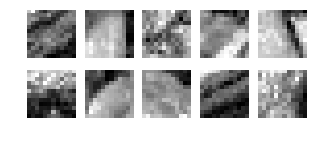

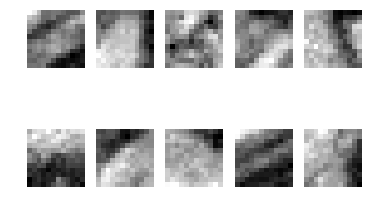

In [19]:
# Up: show the random selected test patches
nrows = 2
ncols = 5
plt.figure(figsize=(ncols, nrows))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(test[:,i].reshape((12,12)), cmap="gray")
    plt.axis("off")
plt.show()

# Bottom: show the reconstruction of test patches using sparse representation X
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(re_test[:,i].reshape((12,12)), cmap="gray")
    plt.axis("off")
plt.axis("off")
plt.show()

The patches are well reconstructed by the codebook X. The edges and brightness is well captured. 